In [1]:
%matplotlib inline
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
print(torch.__version__)

1.1.0


### Dataset Class (loads data from csv)

In [2]:
reqd_len = 50
channels = 3
classes = 4
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('../data/new_train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('../data/new_test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('../data/new_val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        y = self.df.iloc[idx : idx + reqd_len, 3 : ].values
        ind = np.argmax(np.sum(y, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        assert(label.shape == (classes, ))
        return x, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(58750, 7)
(7300, 7)
(7400, 7)


### Dataloader definitions (provides data in iterable form)

In [3]:
train_batch_size = 8
batch_size = 8
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

# signal, label = next(iter(trainloader))
# print(signal.shape)
# print(label.shape)

In [20]:
def output_size(n, f, p = 0, s = 1):
    ''' Returns output size for given input size (n), filter size (f), padding (p) and stride (s)
    for a convolutional layer
    '''
    return (((n + 2 * p - f) / s) + 1)

output_size(50, 5)
output_size(46, 5)

42.0

In [36]:
# sig, lab = next(iter(trainloader))
# sig2 = sig
# sig = torch.transpose(sig, 1, 2)
# sig = sig.reshape(-1, 150)
# sig_ = sig.numpy()
# sig2_ = sig2.numpy()
# plt.plot(sig_[0])
# plt.plot(sig2_[0])

In [53]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 10, 5)
        self.conv2 = nn.Conv1d(10, 15, 5)
#         self.conv3 = nn.Conv1d(15, 20, 3)
        self.fc1 = nn.Linear(42 * 15, 4)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 4)
        
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    def forward(self, signal):
        signal = torch.transpose(signal, 1, 2)
        out = F.relu(self.conv1(signal))
        out = F.relu(self.conv2(out))
        out = torch.transpose(out, 1, 2)
        out = out.reshape(-1, 42 * 15)
        out = F.log_softmax(self.fc1(out), dim = 1)
        return out

Net = ConvNet()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()

In [54]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

In [55]:
num_epochs = 20
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '../saved_models/new_fc_classifier.pt')

epoch =  0  step =  0  of total steps  48  loss =  1.3419122695922852
epoch =  0  step =  20  of total steps  48  loss =  1.4672551155090332
epoch =  0  step =  40  of total steps  48  loss =  1.4716451168060303
epoch =  0  step =  60  of total steps  48  loss =  1.4235503673553467
epoch =  0  step =  80  of total steps  48  loss =  1.5560842752456665
epoch =  0  step =  100  of total steps  48  loss =  1.2329968214035034
epoch =  0  step =  120  of total steps  48  loss =  1.0912584066390991
epoch =  0  step =  140  of total steps  48  loss =  1.3679611682891846
epoch :  0  /  20  | TL :  1.2259196573740816  | VL :  1.2785096168518066
saving model
epoch =  1  step =  0  of total steps  48  loss =  1.3375508785247803
epoch =  1  step =  20  of total steps  48  loss =  0.8325811624526978
epoch =  1  step =  40  of total steps  48  loss =  1.0472650527954102
epoch =  1  step =  60  of total steps  48  loss =  1.0359572172164917
epoch =  1  step =  80  of total steps  48  loss =  1.578543

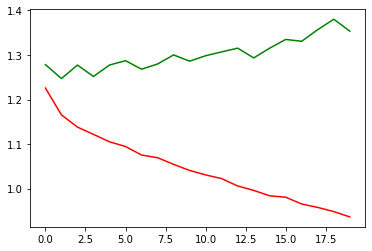

In [56]:
j = np.arange(20)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [57]:
def _get_accuracy(dataloader):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()

        outputs = Net(images)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net.cpu()
# _get_accuracy(trainloader)

ConvNet(
  (conv1): Conv1d(3, 10, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(10, 15, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=630, out_features=4, bias=True)
)

In [58]:
print(_get_accuracy(trainloader))
print(_get_accuracy(testloader))
print(_get_accuracy(valloader))

0.6592465753424658
0.4722222222222222
0.4444444444444444


#### Directly training NNs on raw data doesn't work well (network overfits most of the time). So, we can try to use some pre-processing to the data before training (like running mean, running std deviation, running rms, etc.)

### PyTorch implementation of `running_mean`

In [5]:
def running_mean(signal, window_size = 10):
    ''' Returns running mean of 3D signal (batch_size, length, channels)
    '''
    mean = torch.zeros_like(signal)
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size) : 
            mean[i][j] = signal[i][j : j + window_size].mean(dim = 0)
            
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size, signal.shape[1]) :
            mean[i][j] = signal[i][j]
            
    return mean

### Shows working of `running_mean` function

torch.Size([8, 150, 3])


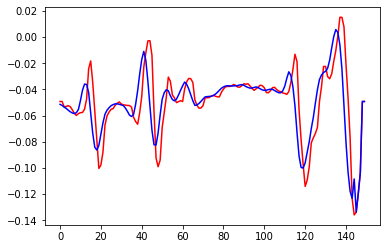

In [8]:
signal, label = next(iter(trainloader))
# print(signal.shape)
# print(signal[2].shape)
# print(signal[2].mean(dim = 0).shape)
# print(signal[2][ : 10].mean(dim = 0).shape)
# print(signal[1][2].shape)
mean = running_mean(signal, window_size = 5)
print(mean.shape)
sig_ = signal[0].transpose(0, 1)
mean_ = mean[0].transpose(0, 1)
t = range(150)
plt.plot(t, sig_[1].data.numpy(), 'r', t, mean_[1].data.numpy(), 'b')

### Training network using `running_mean` processed data

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 5, 3)
        self.fc1 = nn.Linear(148 * 5, 5)
        
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    def forward(self, signal):
        signal_ = running_mean(signal, window_size = 5)
        signal_ = signal_.view(-1, 3, 150)
        out = F.relu(self.conv1(signal_))
        out = out.view(-1, 148 * 5)
        out = F.log_softmax(self.fc1(out), dim = 1)
        return out

Net = ConvNet()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()

In [10]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3, weight_decay = 1e-3)

In [11]:
num_epochs = 20
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '1conv_softmax.pt')

epoch =  0  step =  0  of total steps  106  loss =  1.5382548570632935
epoch =  0  step =  20  of total steps  106  loss =  2.0540518760681152
epoch =  0  step =  40  of total steps  106  loss =  1.498380422592163
epoch =  0  step =  60  of total steps  106  loss =  1.5275654792785645
epoch =  0  step =  80  of total steps  106  loss =  1.9702608585357666
epoch =  0  step =  100  of total steps  106  loss =  1.3912906646728516
epoch :  0  /  20  | TL :  1.5100063715340957  | VL :  1.523334264755249
saving model
epoch =  1  step =  0  of total steps  106  loss =  1.4645376205444336
epoch =  1  step =  20  of total steps  106  loss =  1.71355402469635
epoch =  1  step =  40  of total steps  106  loss =  1.6008198261260986
epoch =  1  step =  60  of total steps  106  loss =  1.5929672718048096
epoch =  1  step =  80  of total steps  106  loss =  1.2262083292007446
epoch =  1  step =  100  of total steps  106  loss =  1.345224380493164
epoch :  1  /  20  | TL :  1.4471513145374801  | VL : 

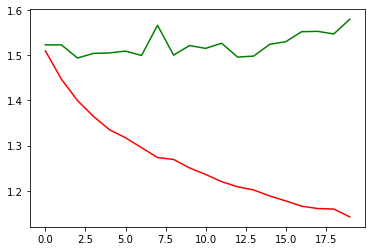

In [12]:
j = np.arange(20)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [13]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()

        outputs = Net(images)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.cpu().eval()
# _get_accuracy(trainloader)

In [14]:
print(_get_accuracy(trainloader, Net))
print(_get_accuracy(testloader, Net))
print(_get_accuracy(valloader, Net))

0.5766509433962265
0.4326923076923077
0.375


In [16]:
testing_Net = ConvNet()
testing_Net.load_state_dict(torch.load('1conv_softmax.pt'))
testing_Net.eval()
print(_get_accuracy(trainloader, testing_Net))
print(_get_accuracy(testloader, testing_Net))
print(_get_accuracy(valloader, testing_Net))

0.4339622641509434
0.4326923076923077
0.3557692307692308


#### Even using `running_mean` processed data, the network again overfits. Even increasing window size didn't help (decreasing won't help as it will be closer to raw data then). Increasing too much is also not helpful as the plot will get more and more flat. So, we need to try out other features.

### PyTorch implementation of running standard deviation

In [5]:
def running_std_dev(signal, window_size = 10):
    ''' Returns running standard deviation of 3D signal (batch_size, length, channels)
    '''
    mean = torch.zeros_like(signal)
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size) : 
            mean[i][j] = signal[i][j : j + window_size].std(dim = 0)
            
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size, signal.shape[1]) :
            mean[i][j] = signal[i][j]
            
    return mean

### Shows working of `running_std_dev` function

torch.Size([8, 150, 3])


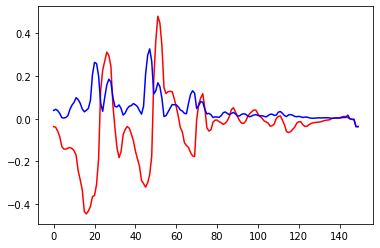

In [6]:
signal, label = next(iter(trainloader))
mean = running_std_dev(signal, window_size = 5)
print(mean.shape)
sig_ = signal[0].transpose(0, 1)
mean_ = mean[0].transpose(0, 1)
t = range(150)
plt.plot(t, sig_[0].data.numpy(), 'r', t, mean_[0].data.numpy(), 'b')

### Training network using `running_std_dev` processed data

In [52]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 5, 3)
        self.conv2 = nn.Conv1d(5, 5, 3)
        self.fc1 = nn.Linear(146 * 5, 5)
        self.mp = nn.MaxPool1d(2, 2)
        self.dropout = nn.Dropout(p = 0.5)
        self.bn1 = nn.BatchNorm1d(num_features = 5)
        self.bn2 = nn.BatchNorm1d(num_features = 5)
        self.bnfc = nn.BatchNorm1d(num_features = 5)
        
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    def forward(self, signal):
        signal_ = running_std_dev(signal, window_size = 10)
        signal_ = signal_.view(-1, 3, 150)
        out = F.relu(self.conv1(signal_))
        out = self.bn1(out)
        out = F.relu(self.conv2(out))
        out = self.bn2(out)
        out = out.view(-1, 146 * 5)
        out = F.log_softmax(self.bnfc(self.fc1(out)), dim = 1)
        return out

Net = ConvNet()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()

In [50]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

In [51]:
num_epochs = 30
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '1conv_softmax.pt')

epoch =  0  step =  0  of total steps  100  loss =  1.7535799741744995
epoch =  0  step =  20  of total steps  100  loss =  1.4038560390472412
epoch =  0  step =  40  of total steps  100  loss =  1.8173305988311768
epoch =  0  step =  60  of total steps  100  loss =  1.44193696975708
epoch =  0  step =  80  of total steps  100  loss =  1.6700127124786377
epoch :  0  /  30  | TL :  1.6008486104011537  | VL :  1.495129942893982
saving model
epoch =  1  step =  0  of total steps  100  loss =  1.7376351356506348
epoch =  1  step =  20  of total steps  100  loss =  1.5920422077178955
epoch =  1  step =  40  of total steps  100  loss =  1.5215744972229004
epoch =  1  step =  60  of total steps  100  loss =  1.3584239482879639
epoch =  1  step =  80  of total steps  100  loss =  1.5897986888885498
epoch :  1  /  30  | TL :  1.5530111646652223  | VL :  1.4726649522781372
saving model
epoch =  2  step =  0  of total steps  100  loss =  1.594433069229126
epoch =  2  step =  20  of total steps  1

KeyboardInterrupt: 

In [ ]:
j = np.arange(200)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [ ]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()

        outputs = Net(images)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.cpu().eval()
# _get_accuracy(trainloader)

In [ ]:
print(_get_accuracy(trainloader, Net) * 100, '/', _get_accuracy(valloader, Net) * 100, '/', _get_accuracy(testloader, Net) * 100)

In [ ]:
testing_Net = ConvNet()
testing_Net.load_state_dict(torch.load('1conv_softmax.pt'))
testing_Net.eval()
print(_get_accuracy(trainloader, testing_Net) * 100, '/', _get_accuracy(valloader, testing_Net) * 100, '/', _get_accuracy(testloader, testing_Net) * 100)

Even using running standard deviation of raw data doesn't help reduce overfitting significantly. So, next we try using running RMS of raw data.

### PyTorch implementation of `running_rms`

In [53]:
def running_rms(signal, window_size = 10):
    ''' Returns running rms of 3D signal (batch_size, length, channels)
    Note : torch.norm just gives vector 2-norm, so we need to divide it by
    sqrt(window_size) to make it the RMS value
    '''
    mean = torch.zeros_like(signal)
    n = np.sqrt(window_size)
    div = torch.tensor(np.array([n, n, n])).float()
    if torch.cuda.is_available() : 
        div = div.cuda()
    
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size) : 
            mean[i][j] = signal[i][j : j + window_size].norm(dim = 0) / div
            
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size, signal.shape[1]) :
            mean[i][j] = signal[i][j]
            
    return mean

### Shows working of `running_rms`

torch.Size([8, 150, 3])


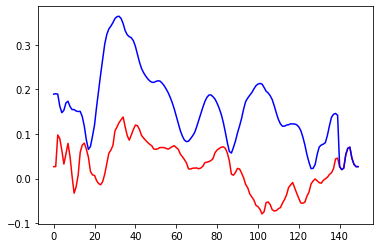

In [67]:
signal, label = next(iter(trainloader))
if torch.cuda.is_available() :
    signal = signal.cuda().float()
rms = running_rms(signal, window_size = 10)
print(rms.shape)
sig_ = signal[0].transpose(0, 1).cpu()
mean_ = rms[0].transpose(0, 1).cpu()
t = range(150)
plt.plot(t, sig_[1].data.numpy(), 'r', t, mean_[1].data.numpy(), 'b')

### Training network using `running_rms` processed data

In [62]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 5, 3)
        self.conv2 = nn.Conv1d(5, 5, 3)
        self.fc1 = nn.Linear(146 * 5, 5)
#         self.mp = nn.MaxPool1d(2, 2)
#         self.dropout = nn.Dropout(p = 0.5)
#         self.bn1 = nn.BatchNorm1d(num_features = 5)
#         self.bn2 = nn.BatchNorm1d(num_features = 5)
#         self.bnfc = nn.BatchNorm1d(num_features = 5)
        
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    def forward(self, signal):
        signal_ = running_rms(signal, window_size = 10)
        signal_ = signal_.view(-1, 3, 150)
        out = F.relu(self.conv1(signal_))
        out = F.relu(self.conv2(out))
        out = out.view(-1, 146 * 5)
        out = F.log_softmax(self.fc1(out), dim = 1)
        return out

Net = ConvNet()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()

In [63]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

In [ ]:
num_epochs = 30
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '1conv_softmax.pt')

In [ ]:
j = np.arange(30)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [ ]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()
        
        if torch.cuda.is_available() : 
            images = images.cuda()
            labels = labels.cuda()

        outputs = Net(images)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.cpu().numpy()
        pred_ind = pred_ind.data.cpu().numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.eval().cuda()

print(_get_accuracy(trainloader, Net) * 100, '/', _get_accuracy(valloader, Net) * 100, '/', _get_accuracy(testloader, Net) * 100)

testing_Net = ConvNet()
testing_Net.load_state_dict(torch.load('1conv_softmax.pt'))
testing_Net.eval().cuda()
print(_get_accuracy(trainloader, testing_Net) * 100, '/', _get_accuracy(valloader, testing_Net) * 100, '/', _get_accuracy(testloader, testing_Net) * 100)